In [ ]:
!pip install comet_ml

In [2]:
from __future__ import print_function
# from comet_ml import Experiment
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

models = keras.models
layers = keras.layers

## Data

In [3]:
np.random.seed(1337)  # for reproducibility

n = 600  # number of data samples
nb_dim = 4  # number of dimensions
R = 1.1  # radius of hypersphere
xdata = 2 * np.random.rand(n, nb_dim) - 1  # features , shape:(n,nb_dim)
ydata = np.sum(xdata ** 2, axis=1) ** 0.5 < R  # labels, True if |x|^2 < R^2, else False, shape:(n,)

# add some normal distributed noise with sigma = 0.1
xdata += 0.1 * np.random.randn(n, nb_dim)
ynoise = np.sum(xdata ** 2, axis=1) ** 0.5 < R

max_acc = np.sum(ynoise==ydata) / n
print(max_acc)

0.8766666666666667


In [4]:
# turn class labels into one-hot encodings
# 0 --> (1, 0), outside of sphere
# 1 --> (0, 1), inside sphere
y1h = np.stack([~ydata, ydata], axis=-1)

# split data into training, validation and test sets of equal size
n_split = n // 3  # 1/3 of the data
X_train, X_valid, X_test = np.split(xdata, [n_split, 2 * n_split])
y_train, y_valid, y_test = np.split(y1h, [n_split, 2 * n_split])

print("  Training set, shape =", np.shape(X_train), np.shape(y_train))
print("Validation set, shape =", np.shape(X_valid), np.shape(y_valid))
print("      Test set, shape =", np.shape(X_test), np.shape(y_test))

  Training set, shape = (200, 4) (200, 2)
Validation set, shape = (200, 4) (200, 2)
      Test set, shape = (200, 4) (200, 2)


## Model

In [5]:
model = models.Sequential([
    layers.InputLayer(input_shape=4, name='input'),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(2, activation='softmax', name='output'),
])

model.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=8,verbose=1)

fit = model.fit(
    X_train,
    y_train,  # training data
    batch_size=n_split,  # no mini-batches, see next lecture
    epochs=4000,  # number of training epochs
    verbose=2,  # verbosity of shell output (0: none, 1: high, 2: low)
    validation_data=(X_valid, y_valid),  # validation data
    callbacks=[callback],
)  # optional list of functions to be called once per epoch

# print a summary of the network layout
print(model.summary())

Streaming output truncated to the last 5000 lines.
Epoch 1511/4000
1/1 - 0s - loss: 0.5120 - accuracy: 0.7400 - val_loss: 0.5813 - val_accuracy: 0.7000 - 31ms/epoch - 31ms/step
Epoch 1512/4000
1/1 - 0s - loss: 0.5118 - accuracy: 0.7400 - val_loss: 0.5812 - val_accuracy: 0.7000 - 32ms/epoch - 32ms/step
Epoch 1513/4000
1/1 - 0s - loss: 0.5116 - accuracy: 0.7400 - val_loss: 0.5811 - val_accuracy: 0.7000 - 30ms/epoch - 30ms/step
Epoch 1514/4000
1/1 - 0s - loss: 0.5115 - accuracy: 0.7450 - val_loss: 0.5810 - val_accuracy: 0.7000 - 31ms/epoch - 31ms/step
Epoch 1515/4000
1/1 - 0s - loss: 0.5113 - accuracy: 0.7450 - val_loss: 0.5809 - val_accuracy: 0.7000 - 31ms/epoch - 31ms/step
Epoch 1516/4000
1/1 - 0s - loss: 0.5111 - accuracy: 0.7450 - val_loss: 0.5808 - val_accuracy: 0.7000 - 33ms/epoch - 33ms/step
Epoch 1517/4000
1/1 - 0s - loss: 0.5109 - accuracy: 0.7450 - val_loss: 0.5807 - val_accuracy: 0.7000 - 39ms/epoch - 39ms/step
Epoch 1518/4000
1/1 - 0s - loss: 0.5108 - accuracy: 0.7450 - val_lo

In [7]:
[pred_loss, pred_accuracy] = model.evaluate(X_test, y_test, verbose=0)
print(pred_loss)
print(pred_accuracy)

## History

In [14]:
print(fit.history.keys())

loss_history = {"train":fit.history["loss"],"validation":fit.history["val_loss"]}
acc_history = {"train":fit.history["accuracy"],"validation":fit.history["val_accuracy"]}

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [21]:
def plot_learning_curve(history, title='', ylabel=''):

    total_steps = len(history["train"])
    x_1 = range(total_steps)
    x_2 = x_1[::len(history["train"]) // len(history["validation"])]
    plt.figure(figsize=(6, 4))
    plt.plot(x_1, history["train"], c='tab:red', label='train')
    plt.plot(x_2, history['validation'], c='tab:cyan', label='validation')
    # plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('{}'.format(ylabel))
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.savefig('{}.png'.format(ylabel))
    plt.show()

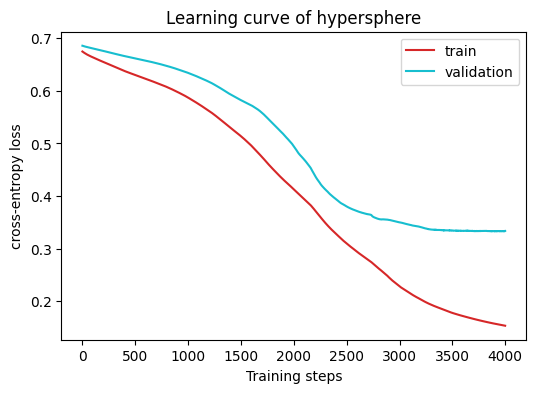

In [22]:
plot_learning_curve(loss_history, title='hypersphere', ylabel='cross-entropy loss')

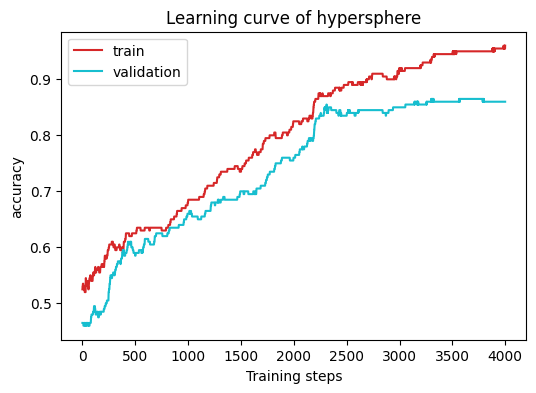

In [20]:
plot_learning_curve(acc_history, title='hypersphere', ylabel='accuracy')